# Dataset ARE

In [ ]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [ ]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('ARE-Historical-Data-final.csv')
df1=df.reset_index()['Price']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 3s 30ms/step - loss: 0.0447 - val_loss: 0.1116
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0103 - val_loss: 0.0415
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.0495
Epoch 4/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0070 - val_loss: 0.0436
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0332
Epoch 6/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0047 - val_loss: 0.0266
Epoch 7/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 0.0195
Epoch 8/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0131
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0089
Epoch 10/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0053
Epoch 11

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

14/14 [==============================] - 0s 2ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
valid_mape = np.mean(np.abs((y_pred_val - yval) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 3.0369903612406217
Testing RMSE: 3.3255506913950965
Testing MAE: 2.1578107749993083
Validation MAE: 2.287989023724724
Testing MAPE: 1.3427036271523152
Validation MAPE: 1.4334336877865876


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[426:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):

    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.28781012]
2


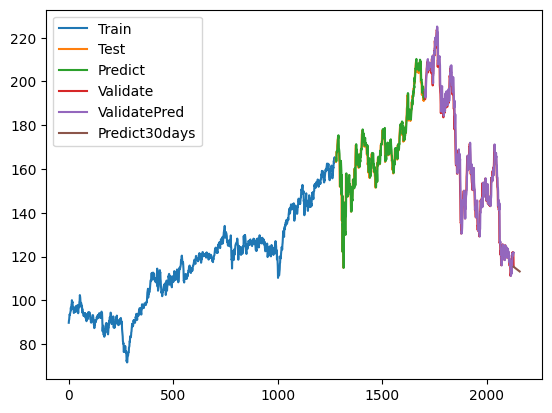

In [ ]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [ ]:
scaler.inverse_transform(lst_output)

array([[115.37411298],
       [115.29833053],
       [115.2226658 ],
       [115.14711879],
       [115.07168496],
       [114.99638244],
       [114.92120216],
       [114.84614412],
       [114.77122191],
       [114.69642648],
       [114.62176234],
       [114.5472295 ],
       [114.47284607],
       [114.39859394],
       [114.32449122],
       [114.25053339],
       [114.17672949],
       [114.10307047],
       [114.02956539],
       [113.95621425],
       [113.88301252],
       [113.80998283],
       [113.73711161],
       [113.66439886],
       [113.59185362],
       [113.51948496],
       [113.44727929],
       [113.37525473],
       [113.30340221],
       [113.23172627]])

# Dataset ARI

In [ ]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('ARI-Historical-Data-final.csv')
df1=df.reset_index()['Price']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 4s 30ms/step - loss: 0.4475 - val_loss: 0.0714
Epoch 2/100
20/20 [==============================] - 0s 6ms/step - loss: 0.1250 - val_loss: 0.0174
Epoch 3/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0468
Epoch 4/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0533
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0456
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0444
Epoch 7/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0453
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0012 - val_loss: 0.0451
Epoch 9/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0448
Epoch 10/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0444
Epoch 11

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

14/14 [==============================] - 0s 2ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
valid_mape = np.mean(np.abs((y_pred_val - yval) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 1.0808588345350554
Testing RMSE: 1.2220937443495627
Testing MAE: 1.0056509718658229
Validation MAE: 1.0057887410780957
Testing MAPE: 10.50301596458301
Validation MAPE: 9.016817720727087


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[426:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):

    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.52977264]
2


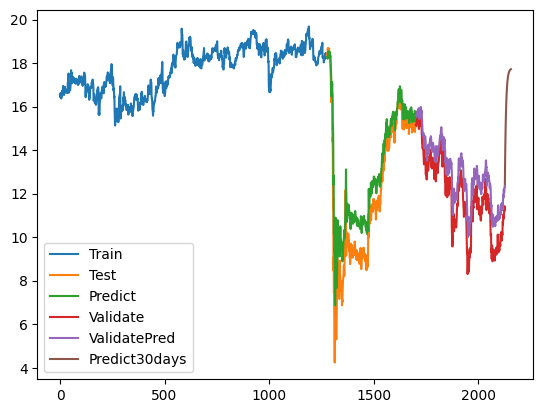

In [ ]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [ ]:
scaler.inverse_transform(lst_output)

array([[12.41968955],
       [13.32298004],
       [14.06344445],
       [14.67369806],
       [15.1787315 ],
       [15.59805044],
       [15.94710112],
       [16.23825876],
       [16.48153249],
       [16.68507245],
       [16.85555815],
       [16.99848192],
       [17.11839461],
       [17.219063  ],
       [17.30361609],
       [17.37466383],
       [17.43438735],
       [17.48460144],
       [17.52683473],
       [17.56236183],
       [17.59225395],
       [17.61740563],
       [17.6385752 ],
       [17.65639028],
       [17.6713865 ],
       [17.68401112],
       [17.69463777],
       [17.70358489],
       [17.71111843],
       [17.7174611 ]])

# Dataset MAA

In [ ]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('MAA-Historical-Data-final.csv')
df1=df.reset_index()['Price']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)


In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define GRU Model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 4s 46ms/step - loss: 0.0171 - val_loss: 0.0634
Epoch 2/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0062 - val_loss: 0.0473
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0051 - val_loss: 0.0475
Epoch 4/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0042 - val_loss: 0.0355
Epoch 5/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0290
Epoch 6/100
20/20 [==============================] - 1s 33ms/step - loss: 0.0025 - val_loss: 0.0209
Epoch 7/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0139
Epoch 8/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0083
Epoch 9/100
20/20 [==============================] - 0s 6ms/step - loss: 7.0879e-04 - val_loss: 0.0044
Epoch 10/100
20/20 [==============================] - 0s 6ms/step - loss: 3.8045e-04 - val_loss: 0.0021

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

14/14 [==============================] - 0s 2ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
valid_mape = np.mean(np.abs((y_pred_val - yval) / np.where(yval != 0, yval, 1))) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 2.907776498045046
Testing RMSE: 2.8900535367957554
Testing MAE: 1.9209171852490574
Validation MAE: 2.24671717744715
Testing MAPE: 1.4983166898138545
Validation MAPE: 1.2683782607100615


In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[426:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):

    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        # print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.53228873]
2


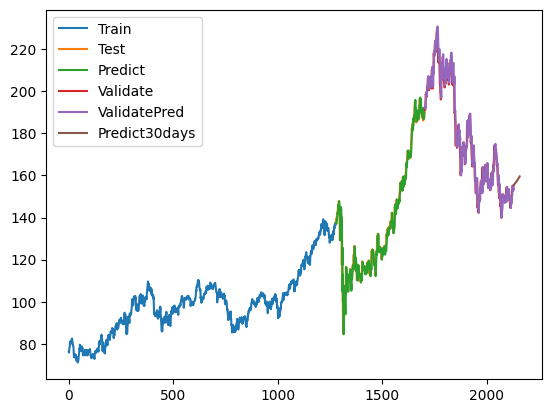

In [ ]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [ ]:
scaler.inverse_transform(lst_output)

array([[155.40598309],
       [155.52355038],
       [155.64273101],
       [155.76354387],
       [155.8860267 ],
       [156.01017948],
       [156.13606828],
       [156.26367421],
       [156.39305388],
       [156.52422617],
       [156.65721938],
       [156.79205239],
       [156.92880066],
       [157.06744532],
       [157.2080147 ],
       [157.35055595],
       [157.49510681],
       [157.64170503],
       [157.79036004],
       [157.94113789],
       [158.09402913],
       [158.24911869],
       [158.40638769],
       [158.56589275],
       [158.72768103],
       [158.89179027],
       [159.05823935],
       [159.22708488],
       [159.39835515],
       [159.57209735]])